# Part_3: Stroke_Prediction - 
17:15 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df= pd.read_csv('c:/1/Stroke_Prediction_NUM.csv')
df.head(5)

,Unnamed: 0,ID,Gender,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke,Age_years,Age_years_10,Gender_C,Ever_Married_C,Type_Of_Work_C,Residence_C,Smoking_Status_C,Age_years_10_C
0,0,30650,Male,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,58.093151,"(53.126, 59.076]",1,1,2,1,1,5
1,1,57008,Female,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,70.076712,"(65.121, 74.11]",0,1,2,0,0,7
2,2,53725,Female,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0,52.041096,"(48.082, 53.126]",0,1,2,1,0,4
3,3,41553,Female,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0,75.104110,"(74.11, 82.137]",0,1,3,0,1,8
4,4,16167,Female,0,0,Yes,Private,Rural,77.67,32.3,smokes,0,32.024658,"(29.055, 36.058]",0,1,2,0,2,1


### <span style="color:blue">1. Analiza poziomu zbilansowania zmiennej wynikowej
</span>

In [2]:
del df['Unnamed: 0']
df.Stroke.value_counts(dropna = False, normalize=True)

0    0.981144
1    0.018856
Name: Stroke, dtype: float64

Zbiór zmiennych wynikowych wymaga zbilansowania. Do bilansowania zmiennych wynikowych stosuję trzy metody:
- class_weight (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistyczne-czesc-4-zastosowanie-class_weight/)
-  oversampling (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistycznej-czesc-2-oversampling/)
- zmiana progu (http://sigmaquality.pl/models/classification/logistic-regression/model-regresji-logistycznej-czesc-3-zmiana-progu-w-modelu-regresji-logistycznej/)

Wszystkie trzy metody powinny dać podobne efekty przy klasyfikacji. Dzisiaj do zbilansowania zbioru zastosuje metodę oversampling. Oversampling odbywa się na zbiorze treningowym więc najpierw trzeba podzielić zbiór na treningowy i testowy.

### <span style="color:blue">2. Podział na zbiór testowy i wynikowy</span>

In [4]:
df2 = df[['Hypertension','Heart_Disease','Avg_Glucose','BMI','Stroke','Age_years','Gender_C','Ever_Married_C','Type_Of_Work_C','Residence_C','Smoking_Status_C','Age_years_10_C']]

In [5]:
y = df2['Stroke']
X = df2.drop('Stroke', axis=1) 

In [6]:
from sklearn.model_selection import train_test_split 
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.33, stratify = y, random_state = 148)

print ('Zbiór X treningowy: ',Xtrain.shape)
print ('Zbiór X testowy:    ', Xtest.shape)
print ('Zbiór y treningowy: ', ytrain.shape)
print ('Zbiór y testowy:    ', ytest.shape)

Zbiór X treningowy:  (19471, 11)
Zbiór X testowy:     (9591, 11)
Zbiór y treningowy:  (19471,)
Zbiór y testowy:     (9591,)


In [7]:
print("ytrain = 0: ", sum(ytrain == 0))
print("ytrain = 1: ", sum(ytrain == 1))

ytrain = 0:  19104
ytrain = 1:  367


In [8]:
Proporcja = sum(ytrain == 0) / sum(ytrain == 1) 
Proporcja = np.round(Proporcja, decimals=0)
Proporcja = Proporcja.astype(int)
print('Ilość 0 Stroke na 1 Stroke: ', Proporcja)

Ilość 0 Stroke na 1 Stroke:  52


In [9]:
ytrain_OVSA = pd.concat([ytrain[ytrain==1]] * Proporcja, axis = 0) 
ytrain_OVSA.count()

19084

Powiękrzyliśmy ilość zmiennych wynikowych 1. Teraz mamy tą samą liczbę wierszy zmiennych wynikowych i zmiennych niezależnych. Teraz wprowadzamy nowe, dodatkowe zmienne 1 do zbioru treningowego.

In [10]:
Xtrain_OVSA = pd.concat([Xtrain.loc[ytrain==1, :]] * Proporcja, axis = 0)
ytrain_OVSA.count()

19084

In [11]:
ytrain_OVSA = pd.concat([ytrain, ytrain_OVSA], axis = 0).reset_index(drop = True)
Xtrain_OVSA = pd.concat([Xtrain, Xtrain_OVSA], axis = 0).reset_index(drop = True)

print("ilość elementów w zbiorze Xtrain:     ", Xtrain.BMI.count())
print("ilość elementów w zbiorze Xtrain_OVSA: ", Xtrain_OVSA.BMI.count())
print("ilość elementów w zbiorze ytrain:     ", ytrain.count())
print("ilość elementów w zbiorze ytrain_OVSA: ", ytrain_OVSA.count())

ilość elementów w zbiorze Xtrain:      19471
ilość elementów w zbiorze Xtrain_OVSA:  38555
ilość elementów w zbiorze ytrain:      19471
ilość elementów w zbiorze ytrain_OVSA:  38555


Poziom zbilansowania zbioru wynikowego:

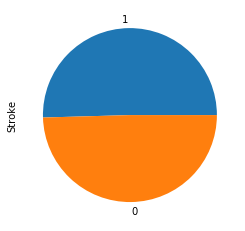

In [12]:
ytrain_OVSA.value_counts(dropna = False, normalize=True).plot(kind='pie')

### <span style="color:blue">3. Model regresji logistycznej</span>

In [13]:
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

Parameteres = {'C': np.power(10.0, np.arange(-3, 3))}
LR = LogisticRegression(warm_start = True)
LR_Grid = GridSearchCV(LR, param_grid = Parameteres, scoring = 'roc_auc', n_jobs = -1, cv=2)

LR_Grid.fit(Xtrain_OVSA, ytrain_OVSA) 
y_pred = LR_Grid.predict(Xtest)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Ocena modelu:

Recall Training data:      0.7956
Precision Training data:   0.752
----------------------------------------------------------------------
Recall Test data:          0.7735
Precision Test data:       0.0517
----------------------------------------------------------------------
Confusion Matrix Test data
[[6841 2569]
 [  41  140]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      9410
           1       0.05      0.77      0.10       181

    accuracy                           0.73      9591
   macro avg       0.52      0.75      0.47      9591
weighted avg       0.98      0.73      0.83      9591



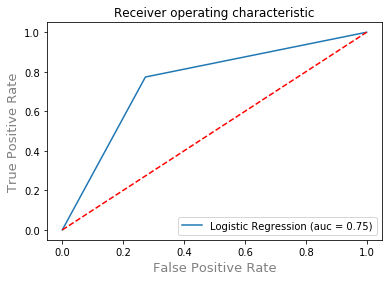

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report

print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, LR_Grid.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, LR_Grid.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, LR_Grid.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, LR_Grid.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, LR_Grid.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, LR_Grid.predict(Xtest)))
y_pred_proba = LR_Grid.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred)
auc = metrics.roc_auc_score(ytest, y_pred)
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

### <span style="color:blue">4. Random Forest Classifier</span>

Hiperparametry:
„n_estimators” - liczba drzew. Większa liczba drzew zwiększa wydajność i sprawia, że prognozy są bardziej stabilne, ale także spowalnia obliczenia.

„N_jobs” - ile procesorów jest dozwolone do użycia. Jeśli ma wartość 1, może używać tylko jednego procesora. Wartość „-1” oznacza, że nie ma limitu.

„Random_state” umożliwia replikację danych wyjściowych modelu. Model zawsze będzie dawał takie same wyniki, gdy ma określoną wartość random_state i jeśli otrzymał te same hiperparametry i te same dane treningowe.

„min_sample_leaf” minimalną liczbę listków wymaganych do podziału wewnętrznego węzła.

## <span style="color:red">Uwaga! Czas obliczeń poniższego modelu trwa 25 minut</span>

In [14]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

import time
start_time = time.time() ## pomiar czasu: start pomiaru czasu
print(time.ctime())
print('Pomiar czasu wykonania tego zadania')

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(Xtrain_OVSA, ytrain_OVSA)

y_pred = CV_rfc.predict(Xtest)



print(time.time() - start_time) ## koniec pomiaru czasu

Mon Mar  2 18:18:18 2020
Pomiar czasu wykonania tego zadania
1544.7481067180634


In [17]:
import pprint
pparam=pprint.PrettyPrinter(indent=2)
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


Recall Training data:      0.9101
Precision Training data:   0.8299
----------------------------------------------------------------------
Recall Test data:          0.6298
Precision Test data:       0.0575
----------------------------------------------------------------------
Confusion Matrix Test data
[[7541 1869]
 [  67  114]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.80      0.89      9410
           1       0.06      0.63      0.11       181

    accuracy                           0.80      9591
   macro avg       0.52      0.72      0.50      9591
weighted avg       0.97      0.80      0.87      9591



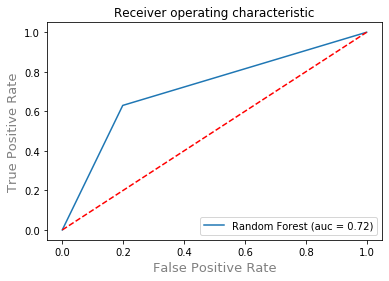

In [18]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report

print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, CV_rfc.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, CV_rfc.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, CV_rfc.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, CV_rfc.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, CV_rfc.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, CV_rfc.predict(Xtest)))
y_pred_proba = CV_rfc.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred)
auc = metrics.roc_auc_score(ytest, y_pred)
plt.plot(fpr, tpr, label='Random Forest (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

Hiperparametry dobrane ręcznie

In [19]:
from sklearn.ensemble import RandomForestClassifier

forestVC = RandomForestClassifier (random_state = 1, 
                                  n_estimators = 350, 
                                  max_depth = 4, 
                                  min_samples_split = 2, min_samples_leaf = 3) 
modelF = forestVC.fit(Xtrain_OVSA, ytrain_OVSA)
y_pred = modelF.predict(Xtest)

Ocena modelu:

Recall Training data:      0.8392
Precision Training data:   0.7562
----------------------------------------------------------------------
Recall Test data:          0.8177
Precision Test data:       0.0521
----------------------------------------------------------------------
Confusion Matrix Test data
[[6720 2690]
 [  33  148]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      9410
           1       0.05      0.82      0.10       181

    accuracy                           0.72      9591
   macro avg       0.52      0.77      0.46      9591
weighted avg       0.98      0.72      0.82      9591



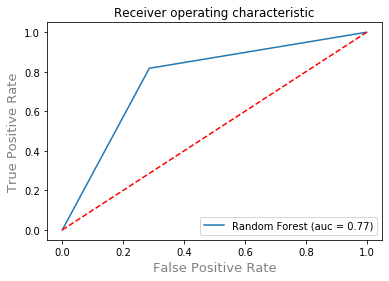

In [20]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report

print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, modelF.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, modelF.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, modelF.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, modelF.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, modelF.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, modelF.predict(Xtest)))
y_pred_proba = modelF.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred)
auc = metrics.roc_auc_score(ytest, y_pred)
plt.plot(fpr, tpr, label='Random Forest (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()

### <span style="color:blue">4. Naive Bayes Classifier</span>

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain_OVSA, ytrain_OVSA)

GaussianNB(priors=None, var_smoothing=1e-09)

y_pred = gnb.predict(Xtest)

Ocena modelu:

Recall Training data:      0.812
Precision Training data:   0.7396
----------------------------------------------------------------------
Recall Test data:          0.779
Precision Test data:       0.0485
----------------------------------------------------------------------
Confusion Matrix Test data
[[6645 2765]
 [  40  141]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      9410
           1       0.05      0.78      0.09       181

    accuracy                           0.71      9591
   macro avg       0.52      0.74      0.46      9591
weighted avg       0.98      0.71      0.81      9591



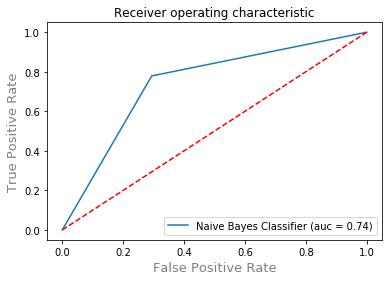

In [22]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, log_loss, auc, roc_curve, roc_auc_score, recall_score, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, fbeta_score, f1_score, classification_report

print("Recall Training data:     ", np.round(recall_score(ytrain_OVSA, gnb.predict(Xtrain_OVSA)), decimals=4))
print("Precision Training data:  ", np.round(precision_score(ytrain_OVSA, gnb.predict(Xtrain_OVSA)), decimals=4))
print("----------------------------------------------------------------------")
print("Recall Test data:         ", np.round(recall_score(ytest, gnb.predict(Xtest)), decimals=4)) 
print("Precision Test data:      ", np.round(precision_score(ytest, gnb.predict(Xtest)), decimals=4))
print("----------------------------------------------------------------------")
print("Confusion Matrix Test data")
print(confusion_matrix(ytest, gnb.predict(Xtest)))
print("----------------------------------------------------------------------")
print(classification_report(ytest, gnb.predict(Xtest)))
y_pred_proba = gnb.predict_proba(Xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest,  y_pred)
auc = metrics.roc_auc_score(ytest, y_pred)
plt.plot(fpr, tpr, label='Naive Bayes Classifier (auc = %0.2f)' % auc)
plt.xlabel('False Positive Rate',color='grey', fontsize = 13)
plt.ylabel('True Positive Rate',color='grey', fontsize = 13)
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--')
plt.show()